In [4]:
import numpy as np
from scipy.stats import t, chi2,f
from numpy import genfromtxt
import cvxpy as cp
import random
import math
import pandas as pd
import itertools

### Dataset Preprocessing and Exploratory Data Analysis

In [5]:
df = pd.read_csv('./Concrete_Data.csv')

In [6]:
df.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Concrete compressive strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [7]:
df = df.replace(to_replace = "Yes",value = 1)
df = df.replace(to_replace = "No",value = 0)
df.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Concrete compressive strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [8]:
df.describe()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Concrete compressive strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.166408,73.894854,54.187379,181.564854,6.203204,972.918932,773.579515,45.662136,35.817961
std,104.507710,86.279340,63.995962,21.355663,5.973035,77.753954,80.175801,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.300000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


# Multiple Regression


In [9]:
def fit(X,Y):
  # finding coefficients
  beta = np.linalg.inv(X.T @ X) @ X.T @ Y
  return beta

def analyse_model(X,Y,beta,print_terms = False):
  k = X.shape[1] - 1
  n = Y.shape[0]

  Y_est = X @ beta
  e = Y - Y_est
  sigma_square_est = (e.T @ e) / (n - k - 1)

  significance=[]

  #testing significance of coefficients
  C = np.linalg.inv(X.T @ X)
  alpha = 0.05
  test_stat_beta = np.zeros(k + 1)

  for i in range(k + 1):
      test_stat_beta[i] = beta[i] / (np.sqrt(sigma_square_est) * np.sqrt(C[i, i]))

  for i in range(k + 1):
      if np.abs(test_stat_beta[i]) > t.ppf(1 - alpha / 2, n - k - 1, loc=0, scale=1):
          print("beta", i, " is significant")
          significance.append(1)
      else:
          print("beta", i, " is not significant")
          significance.append(0)

  #confidence intervals
  l_interval_beta = np.zeros(k + 1)
  h_interval_beta = np.zeros(k + 1)

  for i in range(k + 1):
      l_interval_beta[i] = beta[i] - np.sqrt(sigma_square_est) * t.ppf(1 - alpha / 2, n - k - 1, loc=0, scale=1) * np.sqrt(C[i, i])
      h_interval_beta[i] = beta[i] + np.sqrt(sigma_square_est) * t.ppf(1 - alpha / 2, n - k - 1, loc=0, scale=1) * np.sqrt(C[i, i])
      if print_terms:
        print("95% confidence interval for beta", i, ":", l_interval_beta[i], ",", h_interval_beta[i])

  l_interval_sigma_square = (n - k - 1) * sigma_square_est / chi2.ppf(1 - alpha / 2, df=n - k - 1)
  h_interval_sigma_square = (n - k - 1) * sigma_square_est / chi2.ppf(alpha / 2, df=n - k - 1)
  if print_terms:
    print("95% confidence interval for sigma square :", l_interval_sigma_square, ",", h_interval_sigma_square)

  #ANOVA + coefficient of determination
  SSError = e.T @ e
  SSTotal = (Y - np.mean(Y)).T @ (Y - np.mean(Y))
  SSReg = SSTotal - SSError
  print(SSError)
  print(SSReg)
  test_stat_anova = (SSReg * (n - k - 1)) / (SSError*k)

  if (test_stat_anova < f.ppf(1 - alpha / 2, dfn=k, dfd=n - k -1, loc=0, scale=1)) and (test_stat_anova > f.ppf(alpha / 2, dfn=k, dfd=n - k - 1, loc=0, scale=1)):
      print("The model is insignificant")
  else:
      print("The model is significant")

  R_2 = 1 - (SSError / SSTotal)
  print("R^2 :", R_2)
  R_2_adjusted = 1 - (SSError / SSTotal)*((n-1)/(n-k-1))
  print("R^2_adjusted :", R_2_adjusted)

  return R_2, R_2_adjusted

# Fitting data

In [10]:
X = df.drop(['Concrete compressive strength'],axis = 1)
Y = df['Concrete compressive strength']


X = np.array(X)
Y = np.array(Y)
n = np.size(Y)
X = np.concatenate((np.ones((n,1)),X),axis=1)

beta = fit(X,Y)
analyse_model(X,Y,beta,True)

beta 0  is not significant
beta 1  is significant
beta 2  is significant
beta 3  is significant
beta 4  is significant
beta 5  is significant
beta 6  is not significant
beta 7  is not significant
beta 8  is significant
95% confidence interval for beta 0 : -75.3629247831098 , 28.99309797153876
95% confidence interval for beta 1 : 0.1031263868596557 , 0.13644247541826052
95% confidence interval for beta 2 : 0.08395409217592964 , 0.12373387694918156
95% confidence interval for beta 3 : 0.06323050166274187 , 0.11261943351482583
95% confidence interval for beta 4 : -0.22906982277822316 , -0.07137301332225401
95% confidence interval for beta 5 : 0.10800903807065837 , 0.474720377129265
95% confidence interval for beta 6 : -0.00039623152470726064 , 0.03647377866791838
95% confidence interval for beta 7 : -0.0008533450427624691 , 0.041151857897099506
95% confidence interval for beta 8 : 0.10357558144089146 , 0.12487521307657559
95% confidence interval for sigma square : 99.34516611998573 , 118.

(0.6155069920891918, 0.6124943142603116)

# Polynomial regression (Naive)

In [11]:
def multicollinearity_remover(degree,max_corr,X):
    k=np.shape(X)[1] - 1
    c=[]
    for i in range(k+1):
        c.append(i)
    terms=[]
    for x in itertools.combinations_with_replacement(c, degree):
        terms.append(x)
    new_X=np.zeros((np.shape(X)[0],1))
    for j in range(len(terms)):
        e=np.ones((np.shape(X)[0],1))
        for i in terms[j]:
            t=t1=np.reshape(X[:,i],np.shape(e))
            e=np.multiply(e,t)
        new_X=np.concatenate((new_X,e),axis=1)
    new_X=new_X[:,1:]
    t=pd.DataFrame(new_X[:,1:])
    corr_matrix=np.array(t.corr())
    indices_list = []
    adjunct_terms=[]

    # Iterate through the correlation matrix and store indices with value greater than max_corr
    for i in range(corr_matrix.shape[0]):
        for j in range(i + 1, corr_matrix.shape[1]):  # Only iterate over upper triangle
            if corr_matrix[i, j] > max_corr:
                indices_list.append((i, j))


    for i,j in indices_list:
        adjunct_terms.append(terms[j+1])

    utilizable_terms = []
    for element in terms:
        if element not in adjunct_terms:
            utilizable_terms.append(element)
    new_X=np.zeros((np.shape(X)[0],1))
    for j in range(len(utilizable_terms)):
        e=np.ones((np.shape(X)[0],1))
        for i in utilizable_terms[j]:
            t=t1=np.reshape(X[:,i],np.shape(e))
            e=np.multiply(e,t)
        new_X=np.concatenate((new_X,e),axis=1)
    new_X=new_X[:,1:]
    return (new_X,utilizable_terms)

In [12]:
def fit_upto_degree(X,Y,degree):
  X = np.array(X)
  Y = np.array(Y)
  n = np.size(Y)

  X_modified,usable_terms = multicollinearity_remover(degree,0.98,X) #parameters are degree and max_corr value

  k = np.shape(X_modified)[1] - 1
  print("usable terms")
  print(usable_terms)

  print(X_modified)
  beta = fit(X_modified,Y)
  R2, R2_adj = analyse_model(X_modified,Y,beta)
  return R2, R2_adj


usable terms
[(0,), (1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,)]
[[1.000e+00 5.400e+02 0.000e+00 ... 1.040e+03 6.760e+02 2.800e+01]
 [1.000e+00 5.400e+02 0.000e+00 ... 1.055e+03 6.760e+02 2.800e+01]
 [1.000e+00 3.325e+02 1.425e+02 ... 9.320e+02 5.940e+02 2.700e+02]
 ...
 [1.000e+00 1.485e+02 1.394e+02 ... 8.924e+02 7.800e+02 2.800e+01]
 [1.000e+00 1.591e+02 1.867e+02 ... 9.896e+02 7.889e+02 2.800e+01]
 [1.000e+00 2.609e+02 1.005e+02 ... 8.645e+02 7.615e+02 2.800e+01]]
beta 0  is not significant
beta 1  is significant
beta 2  is significant
beta 3  is significant
beta 4  is significant
beta 5  is significant
beta 6  is not significant
beta 7  is not significant
beta 8  is significant
110416.85149252073
176758.33562592586
The model is significant
R^2 : 0.6155069920891918
R^2_adjusted : 0.6124943142603116
usable terms
[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (2, 2), (2, 3), (2, 5), (2, 8), (3, 3), (

usable terms
[(0, 0, 0, 0, 0), (0, 0, 0, 0, 1), (0, 0, 0, 0, 2), (0, 0, 0, 0, 3), (0, 0, 0, 0, 4), (0, 0, 0, 0, 5), (0, 0, 0, 0, 6), (0, 0, 0, 0, 7), (0, 0, 0, 0, 8), (0, 0, 0, 1, 2), (0, 0, 0, 1, 3), (0, 0, 0, 1, 4), (0, 0, 0, 1, 5), (0, 0, 0, 1, 6), (0, 0, 0, 1, 7), (0, 0, 0, 1, 8), (0, 0, 0, 2, 2), (0, 0, 0, 2, 3), (0, 0, 0, 2, 5), (0, 0, 0, 2, 8), (0, 0, 0, 3, 3), (0, 0, 0, 3, 5), (0, 0, 0, 3, 8), (0, 0, 0, 4, 6), (0, 0, 0, 4, 7), (0, 0, 0, 5, 5), (0, 0, 0, 5, 8), (0, 0, 0, 6, 7), (0, 0, 0, 8, 8), (0, 0, 1, 1, 2), (0, 0, 1, 1, 3), (0, 0, 1, 1, 4), (0, 0, 1, 1, 5), (0, 0, 1, 1, 7), (0, 0, 1, 1, 8), (0, 0, 1, 2, 2), (0, 0, 1, 2, 3), (0, 0, 1, 2, 5), (0, 0, 1, 2, 8), (0, 0, 1, 3, 3), (0, 0, 1, 3, 5), (0, 0, 1, 3, 8), (0, 0, 1, 4, 4), (0, 0, 1, 4, 6), (0, 0, 1, 4, 7), (0, 0, 1, 5, 5), (0, 0, 1, 5, 8), (0, 0, 1, 6, 6), (0, 0, 1, 6, 7), (0, 0, 1, 7, 7), (0, 0, 1, 8, 8), (0, 0, 2, 2, 2), (0, 0, 2, 2, 3), (0, 0, 2, 2, 5), (0, 0, 2, 2, 8), (0, 0, 2, 3, 3), (0, 0, 2, 3, 5), (0, 0, 2, 3, 8), 

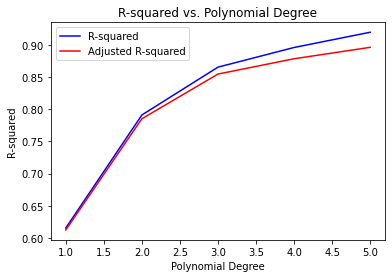

In [13]:
max_degree = 5
R2 = []
R2_adj = []
for d in range(1, max_degree + 1):
    x, y = fit_upto_degree(X, Y, d)
    R2.append(x)
    R2_adj.append(y)

import matplotlib.pyplot as plt
plt.plot([d for d in range(1, max_degree + 1)], R2, label='R-squared', color='blue')
plt.plot([d for d in range(1, max_degree + 1)], R2_adj, label='Adjusted R-squared', color='red')
plt.xlabel('Polynomial Degree')
plt.ylabel('R-squared')
plt.title('R-squared vs. Polynomial Degree')
plt.legend()
plt.show()

# Principal Component Regression

In [14]:
from numpy.linalg import eig
from sklearn.datasets import load_diabetes
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error
import numpy as np

# Load the diabetes dataset
from sklearn.pipeline import Pipeline

def gram_schmidt(vectors):
  num_vectors = vectors.shape[0]
  basis = np.zeros_like(vectors)

  for i in range(num_vectors):
      # Orthogonalize
      basis[i] = vectors[i]
      for j in range(i):
          basis[i] -= np.dot(basis[j], vectors[i]) / np.dot(basis[j], basis[j]) * basis[j]

      # Normalize
      basis[i] /= np.linalg.norm(basis[i])

  return basis

def pcr(x,y):
  cov_mat= (x.T @ x)
  eig_vals, eig_vecs = eig(cov_mat)

  print('Eigenvalues \n', eig_vals)
  print('Eigenvectors \n', eig_vecs)

  eig_pairs = [(eig_vals[i], eig_vecs[:,i]) for i in range(len(eig_vals))]
  eig_pairs.sort(key=lambda x: x[0], reverse=True)
  eig_vals_sorted = np.array([x[0] for x in eig_pairs])
  eig_vecs_sorted = np.array([x[1] for x in eig_pairs]).T
  p = gram_schmidt(eig_vecs)
  error = np.linalg.norm(cov_mat - p @ np.diag(eig_vals_sorted) @ p.T)
  print(error)
  total_variance = sum(eig_vals)
  t = 0
  cumulative_sum = 0.0
  for eigenvalue, _ in eig_pairs:
      cumulative_sum += eigenvalue
      t += 1
      if cumulative_sum / total_variance >= 0.85:
          break

  selected_eig_pairs = eig_pairs[:t]
  selected_eigenvalues = [pair[0] for pair in selected_eig_pairs]
  selected_eigenvectors = p[:,:t]
  print(selected_eigenvectors)
  z = x @ selected_eigenvectors
  alpha=np.linalg.inv(z.T @ z) @ z.T @ y

  num_features = x.shape[1]
  alpha_padded = np.pad(alpha, (0, num_features - len(alpha)), mode='constant')
  coefficients_beta= p @ alpha_padded
  return coefficients_beta


In [15]:
def pca(X,y):
  pca = PCA() # Choose components explaining 85% of variance
  X_pca = pca.fit_transform(X)

  # Fit linear regression model
  model = LinearRegression()
  model.fit(X_pca, y)

  # Predict
  y_pred = model.predict(X_pca)

  # Calculate errors
  mae = mean_absolute_error(y, y_pred)
  mse = mean_squared_error(y, y_pred)

  # Calculate SSE
  sse = np.sum((y - y_pred) ** 2)

  # Calculate SST
  sst = np.sum((y - np.mean(y)) ** 2)

  # Calculate R-squared
  r_squared = 1 - (sse / sst)
  n = X.shape[0]
  p = X_pca.shape[1]

  # Calculate adjusted R-squared
  r_squared_adjusted = 1 - ((1 - r_squared) * (n - 1) / (n - p - 1))

  print("Adjusted R-squared (R2_adjusted):", r_squared_adjusted)
  print("Mean Absolute Error:", mae)
  print("Mean Squared Error:", mse)
  print("Sum of Squared Errors (SSE):", sse)
  print("Total Sum of Squares (SST):", sst)
  print("R-squared (R2):", r_squared)

  return r_squared,r_squared_adjusted

In [16]:
def fit_upto_degree_pcr(X,Y,degree):
  X = np.array(X)
  Y = np.array(Y)
  n = np.size(Y)

  k=np.shape(X)[1] - 1
  c=[]
  for i in range(k+1):
      c.append(i)
  terms=[]
  for x in itertools.combinations_with_replacement(c, degree):
      terms.append(x)
  new_X=np.zeros((np.shape(X)[0],1))
  for j in range(len(terms)):
      e=np.ones((np.shape(X)[0],1))
      for i in terms[j]:
          t=t1=np.reshape(X[:,i],np.shape(e))
          e=np.multiply(e,t)
      new_X=np.concatenate((new_X,e),axis=1)

  X_modified = new_X[:,1:]
  k = np.shape(X_modified)[1] - 1

  R2,R2_adj = pca(X_modified,Y)
  # print(beta)
  # R2, R2_adj = analyse_model(X_modified,Y,beta)
  return R2, R2_adj

Adjusted R-squared (R2_adjusted): 0.6121144067252728
Mean Absolute Error: 8.21442969784791
Mean Squared Error: 107.20082669176769
Sum of Squared Errors (SSE): 110416.85149252071
Total Sum of Squares (SST): 287175.18711844657
R-squared (R2): 0.6155069920891918
Adjusted R-squared (R2_adjusted): 0.801930060053705
Mean Absolute Error: 5.608698196622171
Mean Squared Error: 52.809004607688564
Sum of Squared Errors (SSE): 54393.27474591922
Total Sum of Squares (SST): 287175.18711844657
R-squared (R2): 0.8105920107802194
Adjusted R-squared (R2_adjusted): 0.9112620971158033
Mean Absolute Error: 3.5185268143223998
Mean Squared Error: 20.77386077499252
Sum of Squared Errors (SSE): 21397.076598242296
Total Sum of Squares (SST): 287175.18711844657
R-squared (R2): 0.9254912069077299
Adjusted R-squared (R2_adjusted): 0.9609730529656235
Mean Absolute Error: 1.5532317590839508
Mean Squared Error: 5.646770657171321
Sum of Squared Errors (SSE): 5816.1737768864605
Total Sum of Squares (SST): 287175.187118

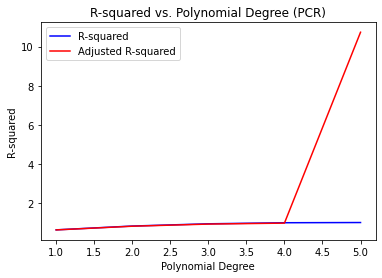

In [17]:
max_degree = 5
R2 = []
R2_adj = []
for d in range(1, max_degree + 1):
    x,y = fit_upto_degree_pcr(X, Y, d)
    R2.append(x)
    R2_adj.append(y)

import matplotlib.pyplot as plt
plt.plot([d for d in range(1, max_degree + 1)], R2, label='R-squared', color='blue')
plt.plot([d for d in range(1, max_degree + 1)], R2_adj, label='Adjusted R-squared', color='red')
plt.xlabel('Polynomial Degree')
plt.ylabel('R-squared')
plt.title('R-squared vs. Polynomial Degree (PCR)')
plt.legend()
plt.show()